In [43]:
import sys
import os
import torch
import matplotlib.pyplot as plt


# Add the path to stylegan2-ada-pytorch directory
repo_path = '/Users/oliverlundin/Local Documents/github/facemorph/stylegan2-ada-pytorch'
sys.path.append(repo_path)

import projector


In [44]:
face1_path = 'emma.png'
face2_path = 'vilma.png'

### Load images and convert to tensors

In [45]:
import torch
from PIL import Image
import numpy as np

face1 = Image.open(face1_path)
face2 = Image.open(face2_path)

# Convert the PIL images to NumPy arrays
face1_array = np.array(face1)
face2_array = np.array(face2)

# Convert NumPy arrays to PyTorch tensors with specified dtype
face1_tensor = torch.tensor(face1_array, dtype=torch.float16)  # Change dtype as needed
face2_tensor = torch.tensor(face2_array, dtype=torch.float16)

# Print the shape of the tensors
print(face1_tensor.shape)
print(face2_tensor.shape)


torch.Size([256, 256, 3])
torch.Size([256, 256, 3])


### Check if we can use GPU, MPS for mac CUDA for nvidia and load the generator

In [46]:
import pickle
import torch.nn.functional as F


# Set device
if(torch.backends.mps.is_available()): # True
    print("MPS is available")
    device = torch.device("mps")


# Load the generator model from the pickle file
with open('ffhq_res256.pkl', 'rb') as f:
	G = pickle.load(f)['G_ema'].to(device) 
    

    

MPS is available


### Change the image tensors to match the generators expected output

Eftersom generatorn är tränad på en viss typ av bilder av en viss storlek måste våra bilder matcha.

In [47]:
face1_tensor = face1_tensor.squeeze()
face1_tensor = face1_tensor.permute(2, 0, 1)
face1_tensor = F.interpolate(face1_tensor.unsqueeze(0), size=(G.img_resolution, G.img_resolution), mode='bilinear', align_corners=False)
face1_tensor = face1_tensor.squeeze(0)

face2_tensor = face2_tensor.squeeze()
face2_tensor = face2_tensor.permute(2, 0, 1)
face2_tensor = F.interpolate(face2_tensor.unsqueeze(0), size=(G.img_resolution, G.img_resolution), mode='bilinear', align_corners=False)
face2_tensor = face2_tensor.squeeze(0)

face1_tensor = face1_tensor.to(device)
face2_tensor = face2_tensor.to(device)

# empty cache
torch.mps.empty_cache()

# Debugging: Print the shapes
print(f"face1_tensor shape: {face1_tensor.shape}")
print(f"face2_tensor shape: {face2_tensor.shape}")
print(f"Expected shape: ({G.img_channels}, {G.img_resolution}, {G.img_resolution})")



face1_tensor shape: torch.Size([3, 256, 256])
face2_tensor shape: torch.Size([3, 256, 256])
Expected shape: (3, 256, 256)


### Project first image into W

In [69]:

# Project the image
projected_w_steps1 = projector.project(
    G,
    target=face1_tensor,  # Your target image tensor
    num_steps=200,  # Number of optimization steps
	device = device,
    verbose=True  # Print optimization progress
)


Computing W midpoint and stddev using 10000 samples...
step    1/200: dist 0.56 loss 10990.33
step    2/200: dist 0.50 loss 10208.44
step    3/200: dist 0.54 loss 9023.83
step    4/200: dist 0.60 loss 6977.93
step    5/200: dist 0.52 loss 4753.04
step    6/200: dist 0.52 loss 3151.74
step    7/200: dist 0.53 loss 2461.51
step    8/200: dist 0.39 loss 2435.96
step    9/200: dist 0.41 loss 2807.95
step   10/200: dist 0.41 loss 3161.86
step   11/200: dist 0.41 loss 3822.32
step   12/200: dist 0.41 loss 4703.07
step   13/200: dist 0.37 loss 5138.69
step   14/200: dist 0.37 loss 4795.81
step   15/200: dist 0.40 loss 3977.65
step   16/200: dist 0.37 loss 2965.06
step   17/200: dist 0.41 loss 2005.19
step   18/200: dist 0.38 loss 1217.25
step   19/200: dist 0.36 loss 720.02
step   20/200: dist 0.36 loss 513.59
step   21/200: dist 0.34 loss 613.38
step   22/200: dist 0.32 loss 958.17
step   23/200: dist 0.35 loss 1295.13
step   24/200: dist 0.34 loss 1478.65
step   25/200: dist 0.35 loss 1405.

### Project second image into W

In [70]:
projected_w_steps2 = projector.project(
    G,
    target=face2_tensor,  # Your target image tensor
    num_steps=200,  # Number of optimization steps
    device=device,
    verbose=True  # Print optimization progress
)

Computing W midpoint and stddev using 10000 samples...
step    1/200: dist 0.57 loss 28534.53
step    2/200: dist 0.55 loss 38879.88
step    3/200: dist 0.57 loss 36598.66
step    4/200: dist 0.61 loss 32736.53
step    5/200: dist 0.58 loss 28106.24
step    6/200: dist 0.55 loss 23572.73
step    7/200: dist 0.55 loss 19813.63
step    8/200: dist 0.52 loss 16355.62
step    9/200: dist 0.51 loss 12925.96
step   10/200: dist 0.51 loss 9497.48
step   11/200: dist 0.47 loss 6659.02
step   12/200: dist 0.49 loss 4945.96
step   13/200: dist 0.46 loss 3974.12
step   14/200: dist 0.49 loss 3382.27
step   15/200: dist 0.50 loss 2968.64
step   16/200: dist 0.46 loss 2669.70
step   17/200: dist 0.48 loss 2674.36
step   18/200: dist 0.46 loss 2844.72
step   19/200: dist 0.45 loss 3023.63
step   20/200: dist 0.44 loss 2919.27
step   21/200: dist 0.45 loss 2547.35
step   22/200: dist 0.44 loss 2068.36
step   23/200: dist 0.46 loss 1643.90
step   24/200: dist 0.41 loss 1340.34
step   25/200: dist 0.41

In [ ]:
projected_w_steps1.shape
projected_w_steps2.shape

In [ ]:
# check if the projected_w_steps1 and projected_w_steps2 are exactly the same
(projected_w_steps1 == projected_w_steps2).all()

### Create projections

Hitta rätt matriser i projektionen

In [71]:
w1 = projected_w_steps1[-1].unsqueeze(0)
w2 = projected_w_steps2[-1].unsqueeze(0)

### Generate first image

Om man vill generera en "ny" bild utifrån den första bilden kan man köra nedanstående två celler. Men det är egentligen inte nödvändigt och man kan skippa dessa steg

In [8]:
img1 = G.synthesis(w1, noise_mode='const', force_fp32=True)

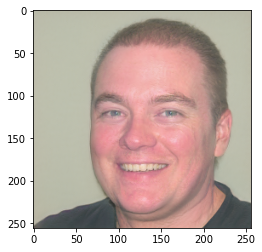

In [9]:
img1 = (img1 + 1) * (255/2)
img1 = img1.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
plt.imshow(img1)

### Generate second image

In [12]:
img2 = G.synthesis(w2, noise_mode='const', force_fp32=True)

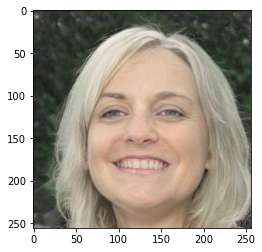

In [11]:
img2 = (img2 + 1) * (255/2)
img2 = img2.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
plt.imshow(img2)

### Interpolate between w1 and w2

Interpolera mellan projektionerna, 10 steg ger 10 bilder

In [72]:
# linear interpolation between w1 and w2
num_interpolations = 10
interpolations = torch.zeros((num_interpolations, w1.shape[1], w1.shape[2]), device=device)
for i in range(num_interpolations):
	interpolations[i] = w1 + (w2 - w1) * i / (num_interpolations - 1)


### Generate the interpolations

Generera 10 bilder utifrån interpolationerna

In [85]:
# Generate the images
interpolated_images = G.synthesis(interpolations, noise_mode='const', force_fp32=True)

Kolla olika bilder utifrån vilket index man stoppar i interpolated_images, 4/5 är någonstanns i mitten och är själva morphen. 0 är bild 1 och 9 är bild 2.

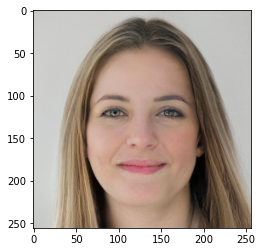

In [86]:
interpolated_images.shape
interpolated_images[5].shape

interpolated_images = (interpolated_images + 1) * (255/2)

interpolated_images = interpolated_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()

# plot the middle image
plt.imshow(interpolated_images[5])

